In [1]:
import jdata as jd
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit as mi
import iminuit.cost as mic
from scipy.optimize import curve_fit
import copy as cp

In [2]:
pendulum_data = jd.load('pendulum_data.json')

In [3]:
period_data = cp.deepcopy(pendulum_data['periods'])

period_data[0][0] = cp.deepcopy(period_data[0][0][-12:])
period_data[1][0] = cp.deepcopy(period_data[1][0][-12:])

period_data[0][2] = cp.deepcopy(period_data[0][2][10:])
period_data[1][2] = cp.deepcopy(period_data[1][2][10:])

In [4]:
def line(x, a,b):
    
    return a*x+b

def gauss(x,height,mu,sig):
    
    return np.exp(-0.5*((x-mu)/sig)**2)*height#/(sig*np.sqrt(2.*np.pi))

a_fits = []
b_fits = []

a_sys_err = []
b_sys_err = []

for per in range(len(pendulum_data['periods'][1])):
    
    measurements = period_data[0][per]
    period = period_data[1][per]

    vals, cov = curve_fit(line, measurements, period)
    
    a_fits.append(vals[0])
    b_fits.append(vals[1])
    
    a_sys_err.append(cov[0])
    b_sys_err.append(cov[1])

<Figure size 640x480 with 0 Axes>

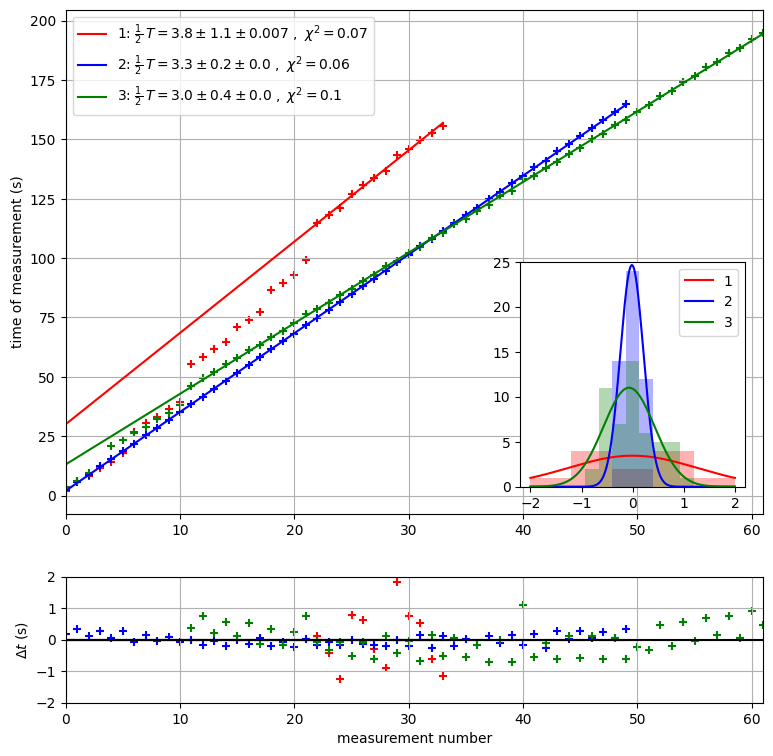

In [5]:
colours = ['red', 'blue', 'green']

fig = plt.figure()
fig, axs = plt.subplots(2,1,figsize=(9,9), gridspec_kw={'height_ratios': [3.2, 0.8]})

max_mes = np.max([len(pendulum_data['periods'][1][ind]) for ind in range(len(pendulum_data['periods'][1]))])

axs[0].set_xlim([0,max_mes])
axs[0].grid()
axs[1].set_xlim([0,max_mes])
axs[1].set_ylim([-2,2])
axs[1].grid()

#fig.tight_layout(pad=-0.1)

position = [0.63, 0.35, 0.25, 0.25]
ax2 = fig.add_axes(position)

best_fits = a_fits
errors = []

binsy = [5,15,15]
ranges = [[-2,2], [-2,2], [-2,2]]

for ind in range(len(pendulum_data['periods'][1])):
    
    period = np.array(pendulum_data['periods'][1][ind])
    
    measurements = np.array(pendulum_data['periods'][0][ind])
    
    chi_per = period_data[1][ind]
    ch_mes = period_data[0][ind]
    
    line_bf = line(measurements, a_fits[ind], b_fits[ind])
    line_res = line(np.array(ch_mes), a_fits[ind], b_fits[ind])
    res = [-line_res[ind]+chi_per[ind] for ind in range(len(chi_per))]
    
    histos = ax2.hist(res, bins = binsy[ind], range = ranges[ind], color = colours[ind], alpha = 0.3)
    histo = histos[0]
    bins = histos[1]
    
    bin_width_half = (bins[1]-bins[0])/2
    bins = bins[0:-1]+bin_width_half
    
        # histo curve fitting
    vals, pcov = curve_fit(gauss, bins, histo)
    
    height = vals[0]
    mu_fits = vals[1]
    sig_fits= vals[2]

    x_vals = np.linspace(-2,2, 1000)
    fit = gauss(x_vals, height, mu_fits, sig_fits)
    
    ax2.plot(x_vals, fit, color = colours[ind], label = str(ind+1))
    
    error = max(x_vals[fit > 0.68*max(fit)])
    errors.append(error)
    
    # get the chi^2
    chi2 = np.sum([(res[ind]**2)/abs(line_res[ind]) for ind in range(len(res))])
    
    label = str(ind+1)+r': $\frac{1}{2}\,T = '+str(np.round(a_fits[ind],1)) + \
            '\pm '+str(np.round(error,1)) +\
            '\pm '+str(np.round(a_sys_err[ind][0],3)) +\
            '\ , \ \chi^{2} = '+str(np.round(chi2,2))+\
            '$'
    
    axs[0].scatter(measurements, period, marker = '+', color = colours[ind])
    axs[0].plot(measurements, line_bf, color = colours[ind], 
                   label = label)
    
    axs[1].plot(measurements, np.zeros(len(measurements)), color = 'black')
    axs[1].scatter(ch_mes, res, color = colours[ind], marker = '+')
    
ax2.set_ylim([0,25])
ax2.legend()
axs[0].legend()
axs[1].set_xlabel('measurement number')
axs[0].set_ylabel('time of measurement (s)')
axs[1].set_ylabel('$\Delta t$ (s)')

fig.savefig('pendulum_periods.pdf')

In [6]:
2*np.array(best_fits)

array([7.69314685, 6.63604418, 5.94755475])

In [7]:
2*np.array(errors)

array([2.20620621, 0.36436436, 0.73273273])

In [8]:
period_fit_err = [2*a_sys_err[ind][0] for ind in range(len(a_sys_err))]

In [9]:
period_fit_err

[0.013370472265402014, 5.703248501458113e-06, 4.073459561553423e-05]

In [10]:
errors = np.sqrt((2*np.array(errors))**2 + (2*np.array(period_fit_err))**2)

In [11]:
errors

array([2.20636826, 0.36436436, 0.73273274])

### Pendulum length measurement

In [12]:
pendulum_data['length']

{'tape': [14.01, 14, 13.85],
 'tape error': [0.01, 0.02, 0.005],
 'laser': [14.109, 14.111, 14.111],
 'laser error': 0.001,
 'pendulum height from floor': [0.108, 0.107, 0.107],
 'floor error': 0.005,
 'pendulum height from wall': 0.02,
 'wall error': 0.005}

In [13]:
tape_mean = np.mean(pendulum_data['length']['tape'])

In [14]:
tape_stat = np.std(pendulum_data['length']['tape'])

In [15]:
tape_sys = np.sqrt(np.sum(np.array(pendulum_data['length']['tape error'])**2))/\
            len(pendulum_data['length']['tape error'])

In [16]:
print('$'+str(np.round(tape_mean,3))+' \pm '+ str(np.round(tape_stat,3))+' \pm '+str(np.round(tape_sys,3))+'$')

$13.953 \pm 0.073 \pm 0.008$


In [17]:
tape_error = np.sqrt(tape_stat**2 + tape_sys**2)

In [18]:
tape_error

0.07357913351548048

In [19]:
length_laser = list(np.array(pendulum_data['length']['laser']) -\
               np.array(pendulum_data['length']['pendulum height from floor'])-\
               np.array(pendulum_data['length']['pendulum height from wall']))

laser_errors = list(np.sqrt(pendulum_data['length']['laser error']**2 +\
                            pendulum_data['length']['floor error']**2 +\
                            pendulum_data['length']['wall error']**2)*np.ones(3))

pendulum_length = pendulum_data['length']['tape']+length_laser
length_errors = pendulum_data['length']['tape error']+laser_errors

In [20]:
laser_mean = np.mean(length_laser)

In [21]:
laser_stat = np.std(length_laser)

In [22]:
laser_sys = np.sqrt(np.sum(np.array(laser_errors)**2))/\
            len(laser_errors)

In [23]:
print('$'+str(np.round(laser_mean,3))+' \pm '+ str(np.round(laser_stat,3))+' \pm '+str(np.round(laser_sys,3))+'$')

$13.983 \pm 0.001 \pm 0.004$


In [24]:
laser_error = np.sqrt(laser_stat**2 + laser_sys**2)

In [25]:
laser_error

0.004358898943540963

In [26]:
length_errors

[0.01,
 0.02,
 0.005,
 0.0071414284285428505,
 0.0071414284285428505,
 0.0071414284285428505]

In [27]:
length_mean = np.sum(pendulum_length)/len(pendulum_length)

In [28]:
length_mean

13.968166666666667

In [29]:
statistical_error = np.sqrt(np.sum([(pendulum_length[ind]-length_mean)**2 
                      for ind in range(len(pendulum_length))])/len(pendulum_length))

systematic_error = np.sqrt(np.sum([length_errors[ind]**2 for ind in range(len(length_errors))]))

error_on_mean = np.sqrt(statistical_error**2 + systematic_error**2)

In [30]:
statistical_error

0.05384055679091353

In [31]:
systematic_error

0.026038433132583076

In [32]:
error_on_mean

0.059806400623642154

### get the values of g for each measurement

In [40]:
def g_value(L,T, sigmaL, sigmaT):
    
    gee = L*(2*np.pi/(T*2))**2
    sig_g = gee*np.sqrt((sigmaL/L)**2 + (2*sigmaT/(2*T))**2)
    
    return gee, sig_g

In [41]:
g_values = []
g_errors = []

for ind in range(len(best_fits)):
    
    bf = best_fits[ind]
    period_error = errors[ind]
    
    gee, gerr = g_value(length_mean,bf, error_on_mean, period_error)
    
    g_values.append(gee)
    g_errors.append(gerr)

In [42]:
g_values

[9.317321893348266, 12.5221991939644, 15.58914324429593]

In [43]:
g_errors

[5.344501128834867, 1.376154165954587, 3.8417132807822587]

### total g

In [44]:
g_val = np.mean(g_values)

g_err = np.sqrt(np.sum(np.array(g_errors)**2))/len(g_errors)

In [45]:
g_val

12.476221443869534

In [46]:
g_err

2.241434400267683

In [48]:
ball_incline = jd.load('ball_on_incline_data.json')

In [49]:
ball_incline

{'ball diameters': {'big': [14.7, 14.8, 14.8], 'small': [12.5, 12.5, 12.5]},
 'ball diameters errors': {'big': 0.1, 'small': 0.1},
 'theta': {'phone measuremnet': [13.7, 13.8, 13.8, 13.8, 13.9],
  'phone measuremnet flipped': [14.0, 13.9, 13.9, 14.0, 14.0],
  'phone measuremnet error': 0.1,
  'pythagoras': {'opposite': [21.85, 22.05, 22.6],
   'adjacent': [89.6, 89.1, 89.15]},
  'pythagoras error': 0.05},
 'hole diameters': [5.5, 4.6, 5.5],
 'gate peak times': {'big ball': {'peak times': [[[1.5506,
      1.5506,
      1.5508,
      1.551,
      1.5512,
      1.5514,
      1.5516,
      1.5518,
      1.552,
      1.5522,
      1.5524,
      1.5526,
      1.5528,
      1.553,
      1.5532,
      1.5534,
      1.5536,
      1.5538,
      1.554,
      1.5542,
      1.5544,
      1.5546,
      1.5548,
      1.555,
      1.5552,
      1.5554,
      1.5556,
      1.5558,
      1.556,
      1.5562,
      1.5564,
      1.5566,
      1.5568,
      1.557,
      1.5572,
      1.5574,
      1.5576,

In [50]:
np.mean(ball_incline['ball diameters']['big'])

14.766666666666666

In [52]:
np.sqrt(np.std(ball_incline['ball diameters']['big'])**2 +\
        np.sqrt(3*ball_incline['ball diameters errors']['big']**2)/3)

0.24486169390328263

In [53]:
np.mean(ball_incline['ball diameters']['small'])

12.5

In [54]:
np.sqrt(np.std(ball_incline['ball diameters']['small'])**2 +\
        np.sqrt(3*ball_incline['ball diameters errors']['small']**2)/3)

0.24028114141347545

In [55]:
np.mean(ball_incline['hole diameters'])

5.2

In [56]:
np.std(ball_incline['hole diameters'])

0.4242640687119287

In [58]:
np.mean(ball_incline['theta']['phone measuremnet'])

13.8

In [59]:
np.std(ball_incline['theta']['phone measuremnet'])

0.06324555320336793

In [60]:
np.mean(ball_incline['theta']['phone measuremnet flipped'])

13.959999999999999

In [65]:
np.mean(ball_incline['theta']['pythagoras']['opposite'])

22.166666666666668

In [66]:
np.sqrt(np.std(ball_incline['theta']['pythagoras']['opposite'])**2+
        np.sqrt(3*ball_incline['theta']['pythagoras error']**2)/3)

0.3597541785928787

In [67]:
np.mean(ball_incline['theta']['pythagoras']['adjacent'])

89.28333333333335

In [68]:
np.sqrt(np.std(ball_incline['theta']['pythagoras']['adjacent'])**2+
        np.sqrt(3*ball_incline['theta']['pythagoras error']**2)/3)

0.2818209875347041